In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import time

#For train-test split
from sklearn.model_selection import train_test_split

#for Random forest algorithm
from sklearn.ensemble import RandomForestClassifier

#for GridSearchCV and RandomSearchCv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#for confusion matrix
from sklearn.metrics import confusion_matrix

#for roc-auc curve
from sklearn.metrics import roc_curve, roc_auc_score

#for Classification Report
from sklearn.metrics import classification_report

Fetching dataset

In [1387]:
df = pd.read_csv('un-encoded_hr_data.csv')

In [1388]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,0,0,0,0,1,0,0,1
1,49,279,8,1,2,3,61,2,2,2,...,0,0,0,0,0,1,0,0,1,0
2,37,1373,2,2,3,4,92,2,1,3,...,0,1,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,4,56,3,1,3,...,0,0,0,0,0,1,0,0,1,0
4,27,591,2,1,5,1,40,3,1,2,...,0,1,0,0,0,0,0,0,1,0


Seperating target variable vs independant variable

In [1389]:
feature_list = df.columns.to_list()
class_ = 'Attrition'
feature_list.remove(class_)

feature_space = df[feature_list]
class_variable = df[class_]

feature_space.head()


,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,0,0,0,0,1,0,0,1
1,49,279,8,1,2,3,61,2,2,2,...,0,0,0,0,0,1,0,0,1,0
2,37,1373,2,2,3,4,92,2,1,3,...,0,1,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,4,56,3,1,3,...,0,0,0,0,0,1,0,0,1,0
4,27,591,2,1,5,1,40,3,1,2,...,0,1,0,0,0,0,0,0,1,0


Train-Test Split

In [1390]:
x_train, x_test, y_train, y_test = train_test_split(feature_space, class_variable, test_size=0.2, random_state=42)

Creating model

In [1391]:
rf_fit = RandomForestClassifier(random_state=42)

Hyper-Parameters for Random forest model

In [1392]:
np.random.seed(42)
start = time.time()

hp = {'criterion' : ['gini', 'entropy'],
      'min_samples_leaf' : [7,9,11],
      'min_samples_split' : [8,10,12],
      'bootstrap' : [True],
      'max_features' : ['auto', 'sqrt', 'log2', None]}

cv_rf = GridSearchCV(rf_fit, n_jobs=-1,
                     param_grid=hp,
                     cv=10)

cv_rf.fit(x_train, y_train)

end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))


Time taken in grid search:  37.18


In [1393]:
print(cv_rf.best_params_)
print('--------------')
print(cv_rf.best_estimator_)

{'bootstrap': True, 'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 8}
--------------
RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=7, min_samples_split=8,
                       random_state=42)


Setting this best parameter in random forest tree model

In [1394]:
rf_fit.set_params(bootstrap = True, 
                  criterion= 'entropy', 
                  max_features=None, 
                  min_samples_leaf= 7, 
                  min_samples_split= 8,
                  oob_score = True)

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=7, min_samples_split=8, oob_score=True,
                       random_state=42)

Finding best n-estimator by oob error rate

In [1395]:
error = {}
min_est = 50
max_est = 800


for i in range(min_est,max_est+1):
    rf_fit.set_params(n_estimators = i, bootstrap=True)
    rf_fit.fit(x_train, y_train)

    oob_error = 1 - rf_fit.oob_score_
    error[i] = oob_error

    if(i%50 == 0):
        clear_output()
        print(((i-min_est)/(max_est-min_est))*100)

#for plotting ease convert dictionary in series
oob_series = pd.Series(error)

print(oob_series)


100.0
50     0.104167
51     0.104167
52     0.101616
53     0.100765
54     0.101190
         ...   
796    0.100765
797    0.100765
798    0.100765
799    0.100765
800    0.100765
Length: 751, dtype: float64


Plotting the oob score

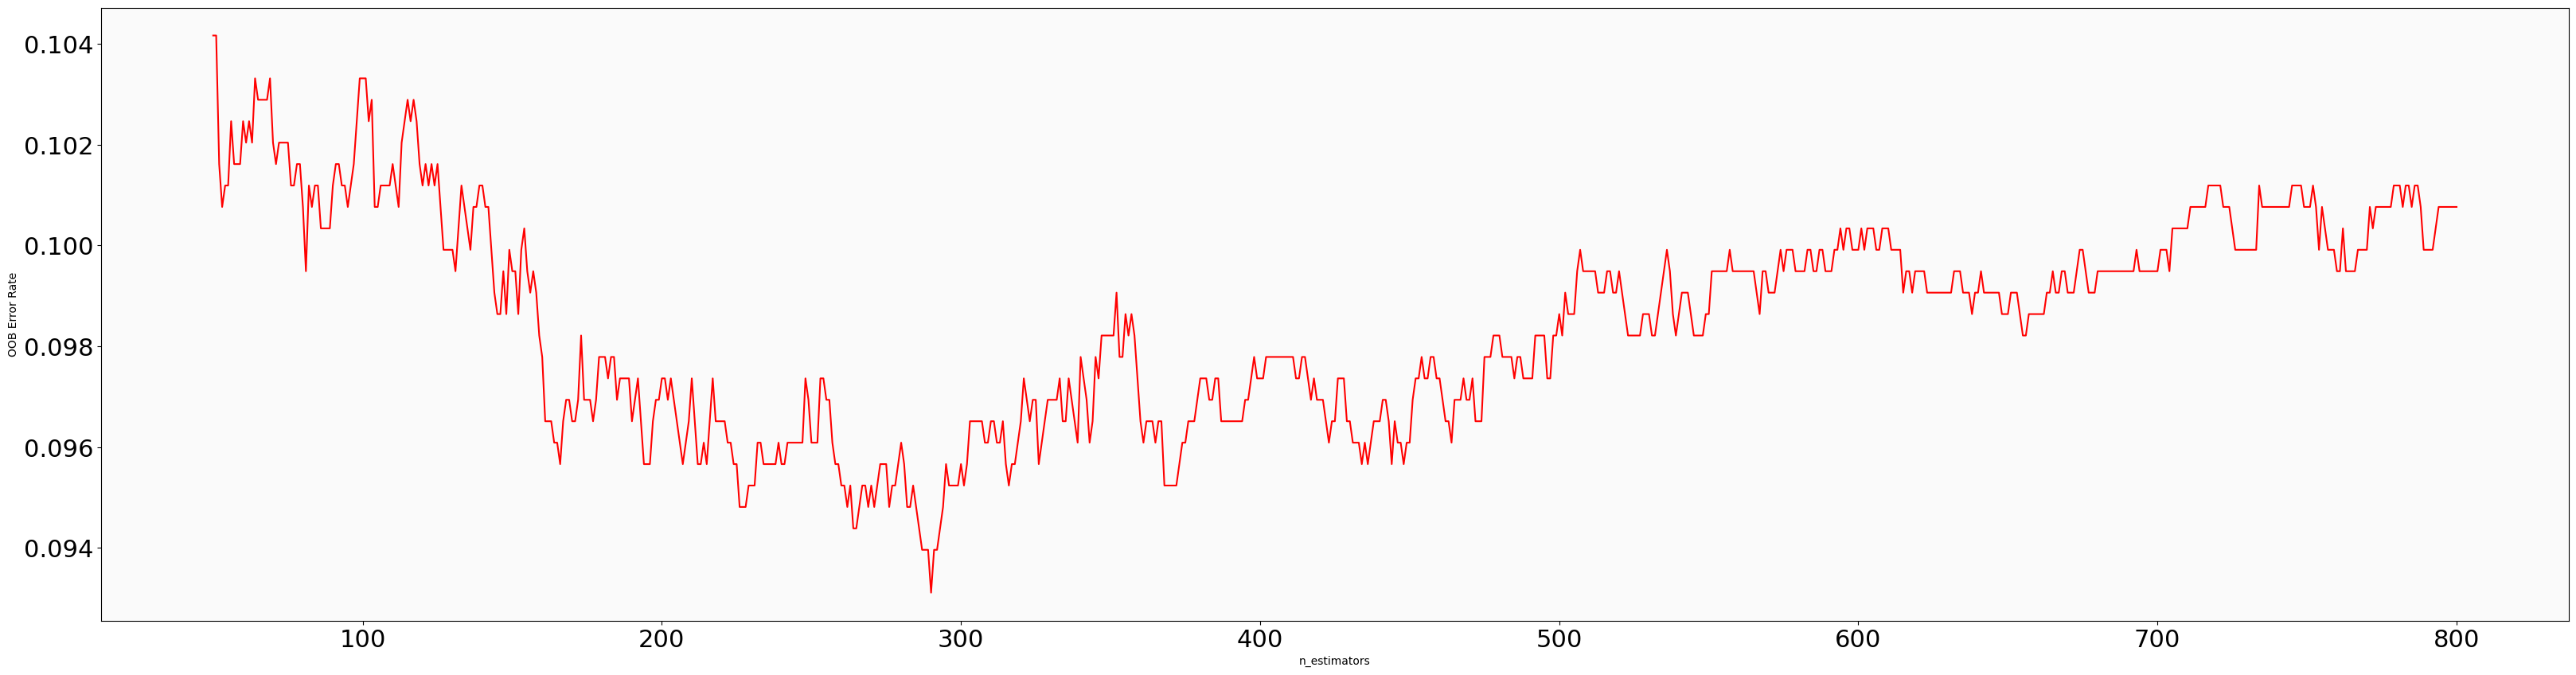

In [1409]:
fig, ax = plt.subplots(figsize=(40, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')

plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
plt.show()

putting optimal n-estimator value

In [1410]:
rf_fit.set_params(n_estimators = 590,
                  bootstrap= True, 
                  criterion= 'entropy',
                  max_features= None, 
                  min_samples_leaf= 3, 
                  min_samples_split= 3,
                  oob_score = True)


RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=590, oob_score=True, random_state=42)

Training the model with optimal parameters

In [1411]:
rf_fit.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=None,
                       min_samples_leaf=3, min_samples_split=3,
                       n_estimators=590, oob_score=True, random_state=42)

Predictions

In [1412]:
pred_rf = rf_fit.predict(x_test)

Accuracy

In [1413]:
accuracy_rf = rf_fit.score(x_test, y_test)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.947


Error Rate

In [1414]:
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.0527


Knowing variable importance according to model

In [1415]:
importances = rf_fit.feature_importances_
indices = np.argsort(importances)[::-1]
print(f'importance: {importances}')
print(f'index: {indices}')

importance: [0.08232015 0.06191964 0.06879396 0.01572376 0.02368915 0.04035154
 0.05435354 0.0263594  0.06295436 0.03242114 0.05595147 0.04164627
 0.03294499 0.02616114 0.03750735 0.02259394 0.02544199 0.0617146
 0.02886132 0.00910707 0.07189766 0.01269086 0.00441226 0.00515673
 0.00726999 0.00549588 0.00417396 0.00691645 0.00083096 0.00732216
 0.00123437 0.00729864 0.00112351 0.00150276 0.00028738 0.00914924
 0.01797202 0.00392222 0.00641697 0.01410919]
index: [ 0 20  2  8  1 17 10  6 11  5 14 12  9 18  7 13 16  4 15 36  3 39 21 35
 19 29 31 24 27 38 25 23 22 26 37 33 30 32 28 34]


In [1416]:
imp_var_names = []
imp_var_val = []

for col in range(0,len(importances)):
    imp_var_names.append(x_train.columns[indices[col]])
    imp_var_val.append(importances[col])

final_var_imp = pd.Series(data = imp_var_val, index= imp_var_names)
final_var_imp = final_var_imp.sort_values(ascending = False)
final_var_imp.columns = ['Var_Name', 'Mean_Impurity_decreased']
print(final_var_imp.columns)

['Var_Name', 'Mean_Impurity_decreased']


<function matplotlib.pyplot.show(close=None, block=None)>

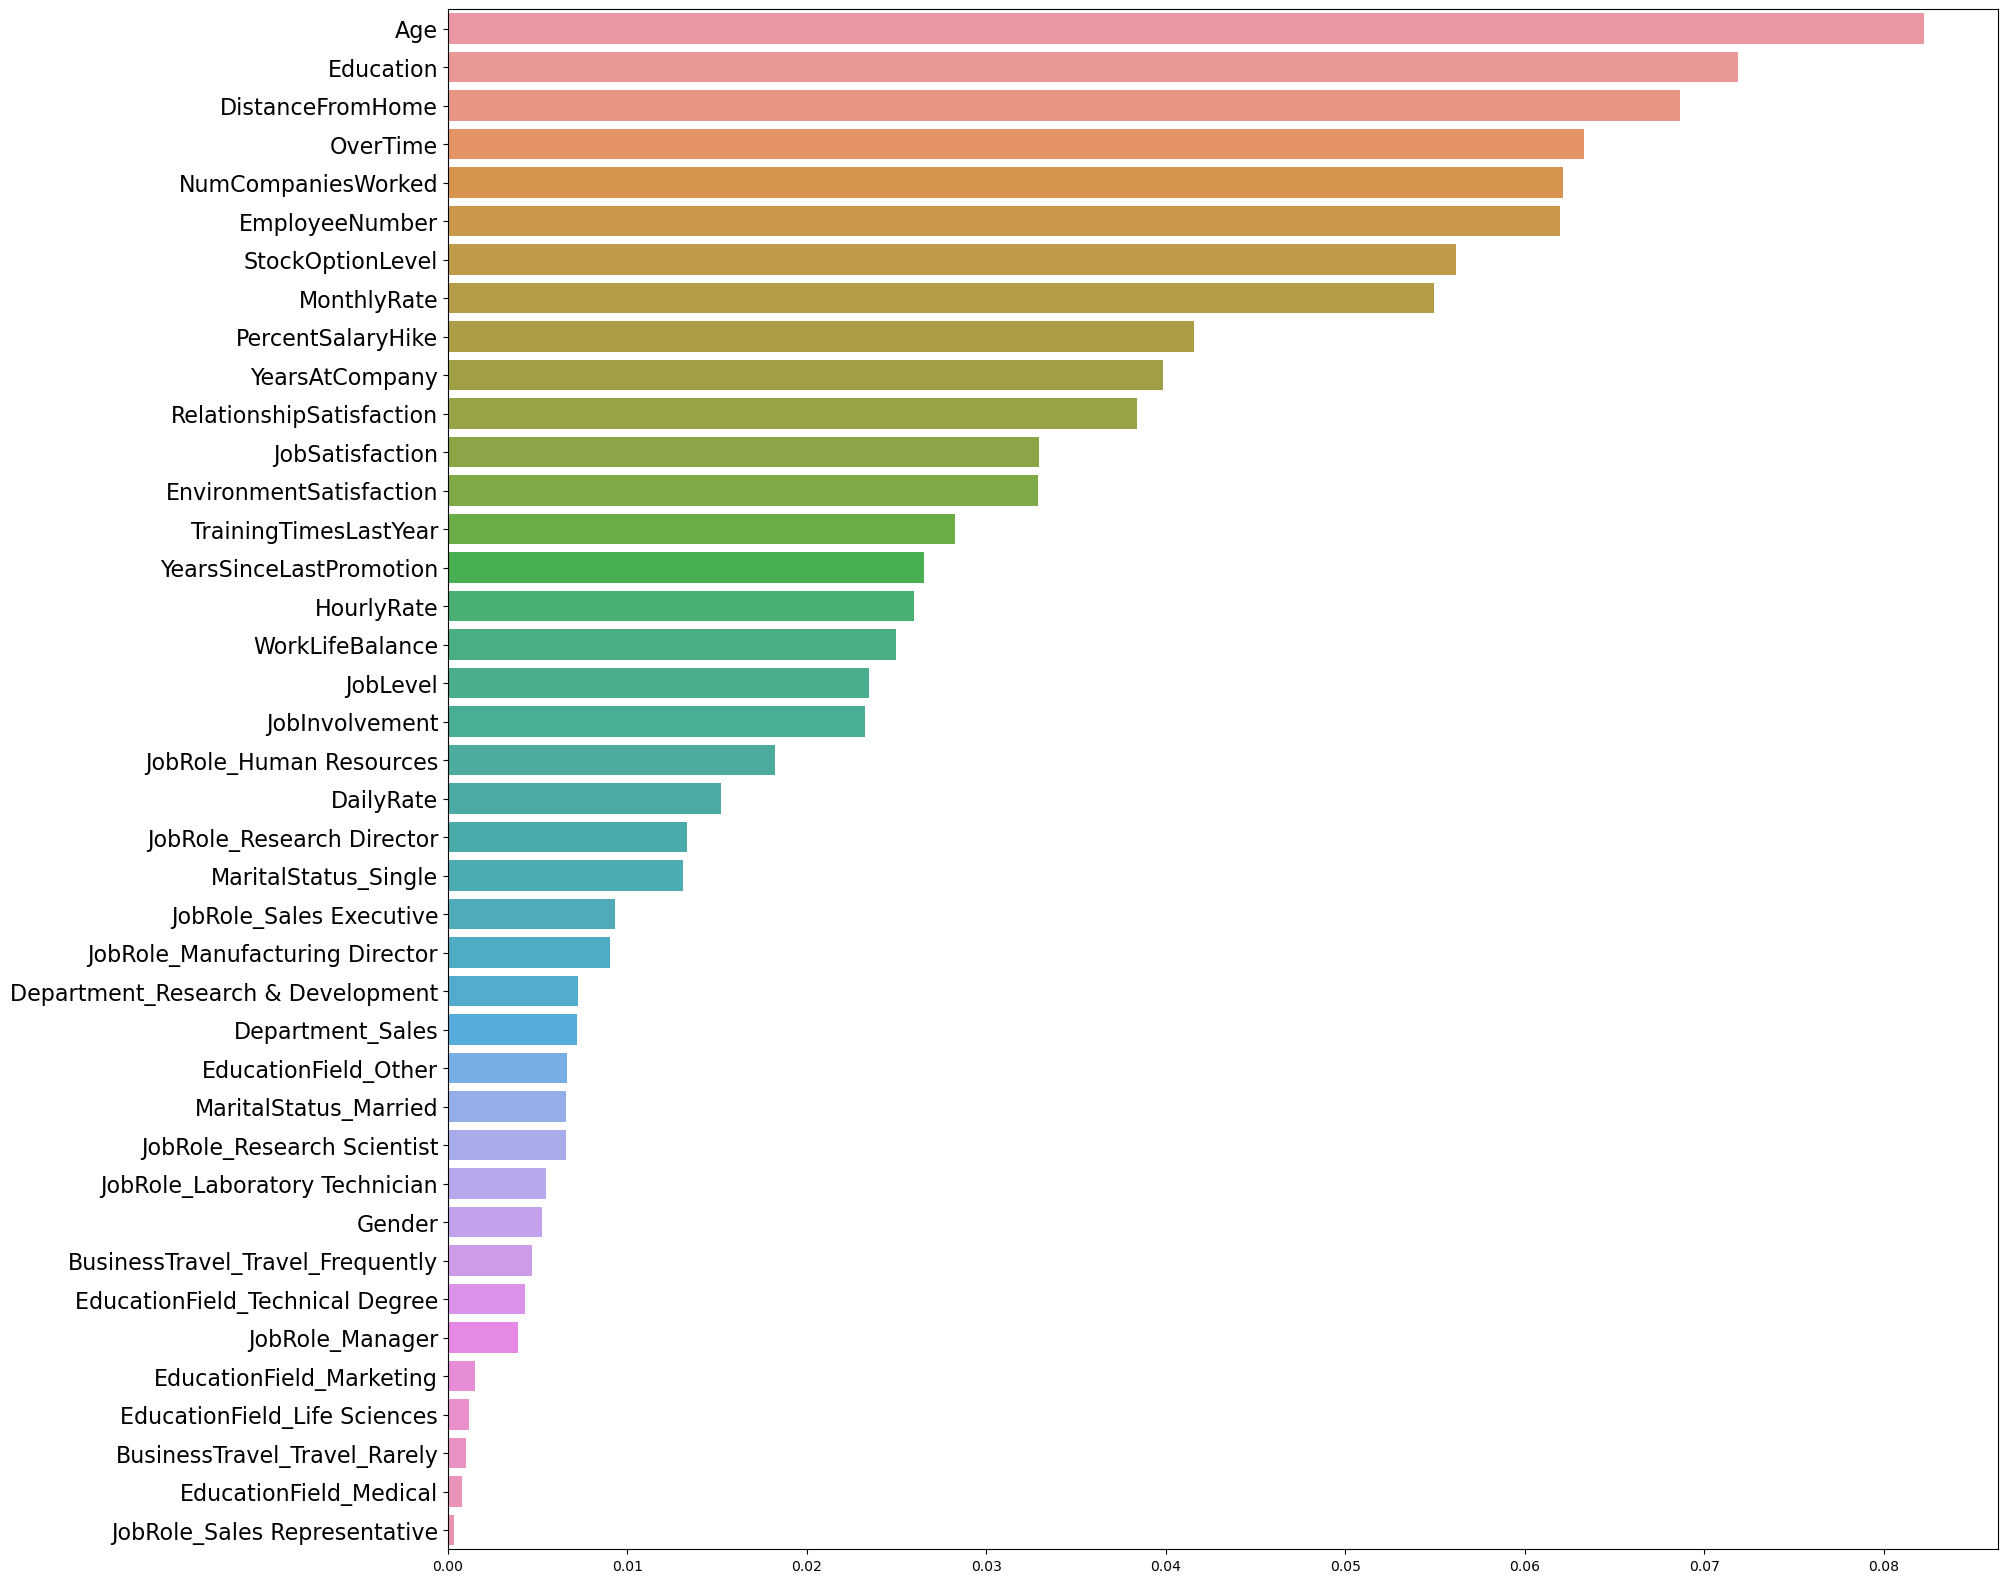

In [1404]:
plt.figure(figsize=[20,20])
sns.barplot(y=final_var_imp.index, x= final_var_imp.values, orient = 'h')
plt.yticks(fontsize = 16)
plt.show

Confusion matrix

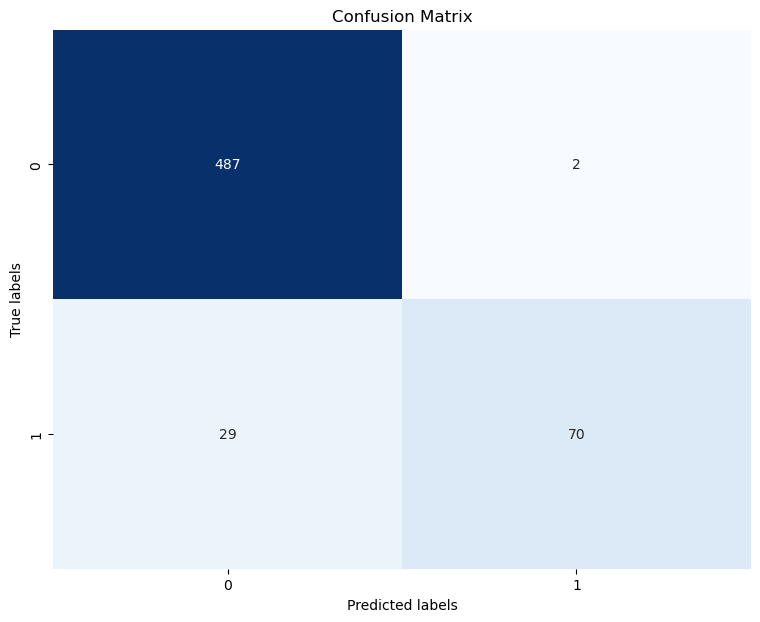

In [1417]:
cm = confusion_matrix(y_test, pred_rf)

plt.figure(figsize=[9,7])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar= False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

AUC curve

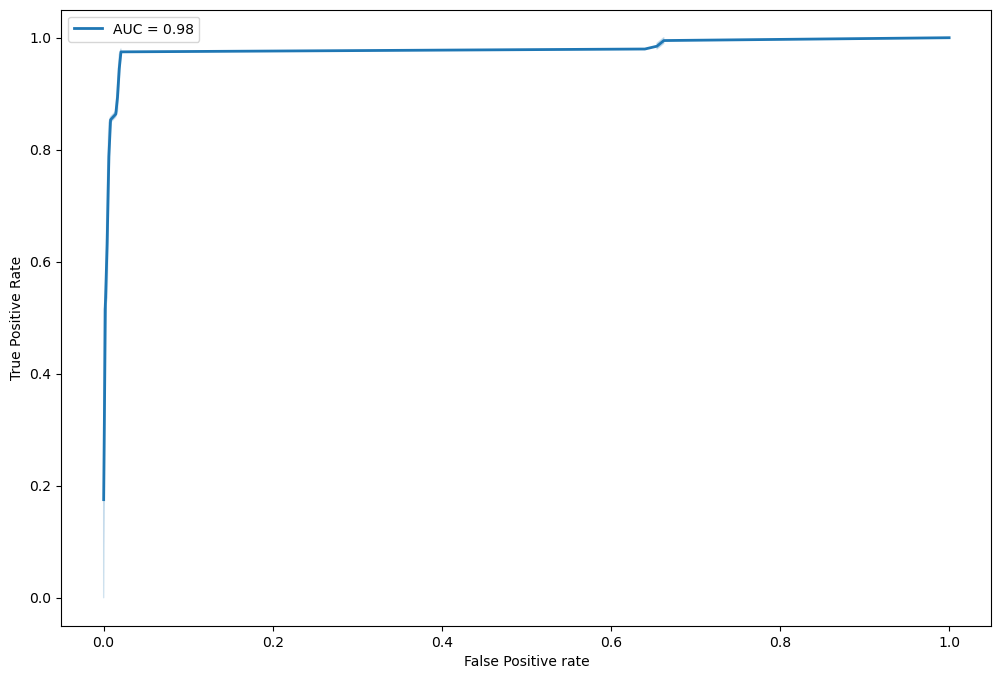

In [1406]:
y_pred_rf = rf_fit.predict_proba(x_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, y_pred_rf)

auc_score = roc_auc_score(y_test, y_pred_rf)

plt.figure(figsize=[12,8])
sns.lineplot(x=fpr, y=tpr, label=f'AUC = {auc_score:.2f}', lw=2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive rate')
plt.show()

Classification Report

In [1418]:
class_report = classification_report(y_test, pred_rf)

print(class_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       489
           1       0.97      0.71      0.82        99

    accuracy                           0.95       588
   macro avg       0.96      0.85      0.89       588
weighted avg       0.95      0.95      0.94       588



In [1408]:
print(rf_fit.score(x_train,y_train))
print(rf_fit.score(x_test,y_test))

0.9940476190476191
0.9472789115646258
